# Preprocessing and clustering

In [1]:
# Core scverse libraries
import scanpy as sc
import anndata as ad

In [2]:
sc.settings.set_figure_params(dpi=77, facecolor="white")

In [3]:
samples = {
    "da1": r"C:\Users\kssri\Downloads\GSE278043\GSE278043_U1_DA_filtered_feature_bc_matrix.h5",
    "mrp8_14": r"C:\Users\kssri\Downloads\GSE278043\GSE278043_U1_MRP8_14_filtered_feature_bc_matrix.h5",
    "nt": r"C:\Users\kssri\Downloads\GSE278043\GSE278043_U1_NT_filtered_feature_bc_matrix.h5",
    "u937_da": r"C:\Users\kssri\Downloads\GSE278043\GSE278043_U937_DA_filtered_feature_bc_matrix.h5",
    "u937_nt": r"C:\Users\kssri\Downloads\GSE278043\GSE278043_U937_NT_filtered_feature_bc_matrix.h5",
}

adatas = {}

for sample_id, filename in samples.items():
    path = (filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

C:\Users\kssri\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\kssri\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\kssri\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\kssri\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\kssri\AppData\Local\Programs\Python\Python3

da1        40555
u937_da    20654
nt         19901
mrp8_14    10146
u937_nt     8721
Name: sample, dtype: int64


C:\Users\kssri\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 99977 × 18935
    obs: 'sample'

The data contains ~8,000 cells per sample and 36,601 measured genes. We'll now investigate these with a basic preprocessing and clustering workflow.

## Quality Control

The scanpy function {func}`~scanpy.pp.calculate_qc_metrics` calculates common quality control (QC) metrics, which are largely based on `calculateQCMetrics` from scater {cite}`McCarthy2017`. One can pass specific gene population to {func}`~scanpy.pp.calculate_qc_metrics` in order to calculate proportions of counts for these populations. Mitochondrial, ribosomal and hemoglobin genes are defined by distinct prefixes as listed below. 

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

One can now inspect violin plots of some of the computed QC metrics:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

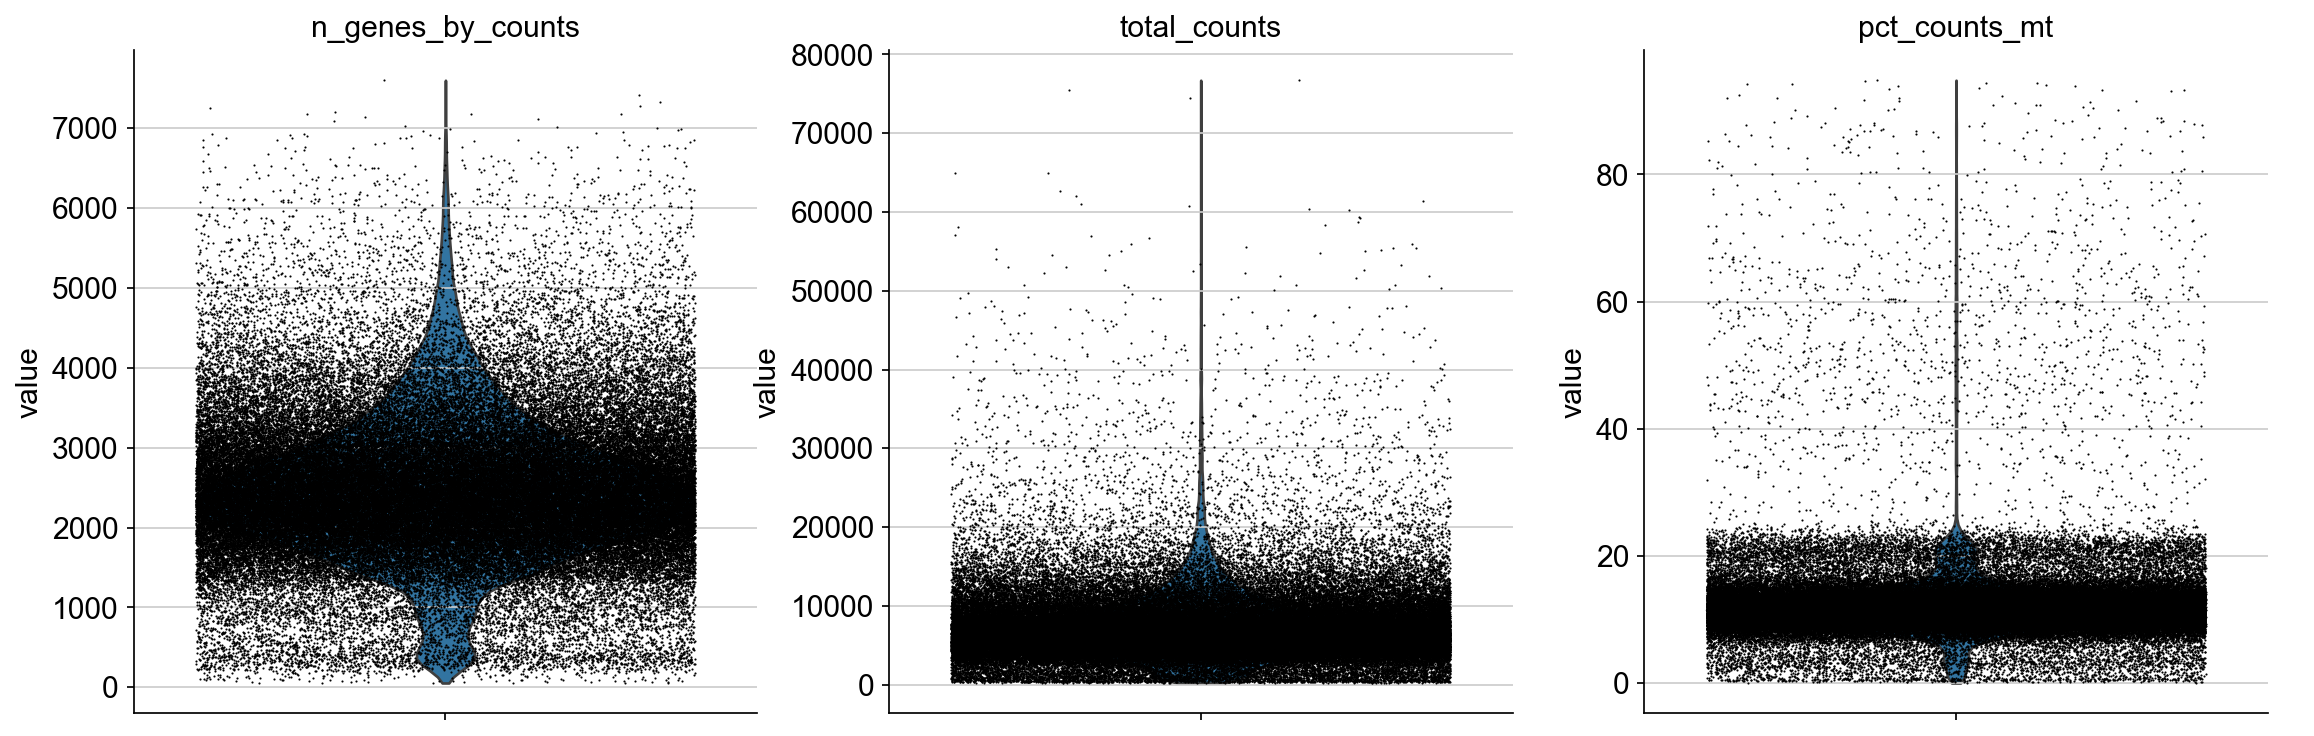

In [6]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Additionally, it is useful to consider QC metrics jointly by inspecting a scatter plot colored by `pct_counts_mt`. 

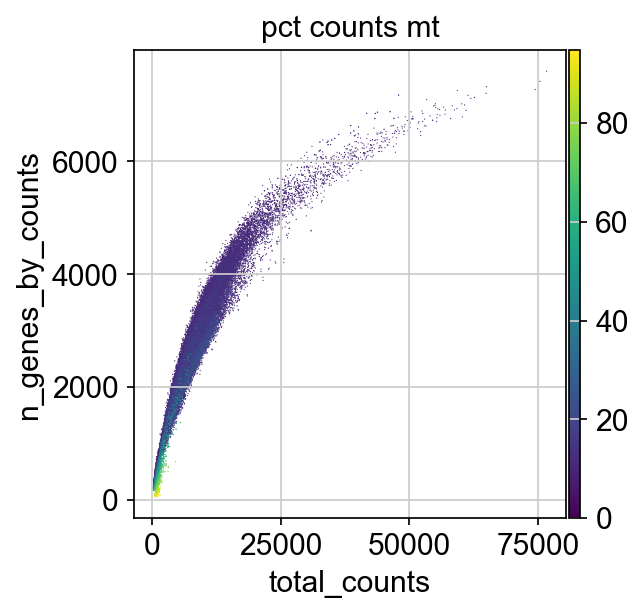

In [7]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Based on the QC metric plots, one could now remove cells that have too many mitochondrial genes expressed or too many total counts by setting manual or automatic thresholds. However, sometimes what appears to be poor QC metrics can be driven by real biology so we suggest starting with a very permissive filtering strategy and revisiting it at a later point. We therefore now only filter cells with less than 100 genes expressed and genes that are detected in less than 3 cells. 

Additionally, it is important to note that for datasets with multiple batches, quality control should be performed for each sample individually as quality control thresholds can very substantially between batches. 

In [8]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

### Doublet detection

As a next step, we run a doublet detection algorithm. Identifying doublets is crucial as they can lead to misclassifications or distortions in downstream analysis steps. Scanpy contains the doublet detection method Scrublet {cite}`Wolock2019`. Scrublet predicts cell doublets using a nearest-neighbor classifier of observed transcriptomes and simulated doublets. {func}`scanpy.pp.scrublet` adds `doublet_score` and `predicted_doublet` to `.obs`. One can now either filter directly on `predicted_doublet` or use the `doublet_score` later during clustering to filter clusters with high doublet scores. 

In [9]:
sc.pp.scrublet(adata, batch_key="sample") #, batch_key="sample"

We can remove doublets by either filtering out the cells called as doublets, or waiting until we've done a clustering pass and filtering out any clusters with high doublet scores.

:::{seealso}
Alternative methods for doublet detection within the scverse ecosystem are [DoubletDetection](https://github.com/JonathanShor/DoubletDetection) and [SOLO](https://docs.scvi-tools.org/en/stable/user_guide/models/solo.html). You can read more about these in the [Doublet Detection chapter](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html#doublet-detection) of Single Cell Best Practices.
:::

## Normalization

The next preprocessing step is normalization. A common approach is count depth scaling with subsequent log plus one (log1p) transformation. Count depth scaling normalizes the data to a “size factor” such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via `target_sum` in `pp.normalize_total`. We are applying median count depth normalization with log1p transformation (AKA log1PF).

In [10]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [11]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

## Feature selection

As a next step, we want to reduce the dimensionality of the dataset and only include the most informative genes. This step is commonly known as feature selection. The scanpy function `pp.highly_variable_genes` annotates highly variable genes by reproducing the implementations of Seurat {cite}`Satija2015`, Cell Ranger {cite}`Zheng2017`, and Seurat v3 {cite}`Stuart2019` depending on the chosen `flavor`. 

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

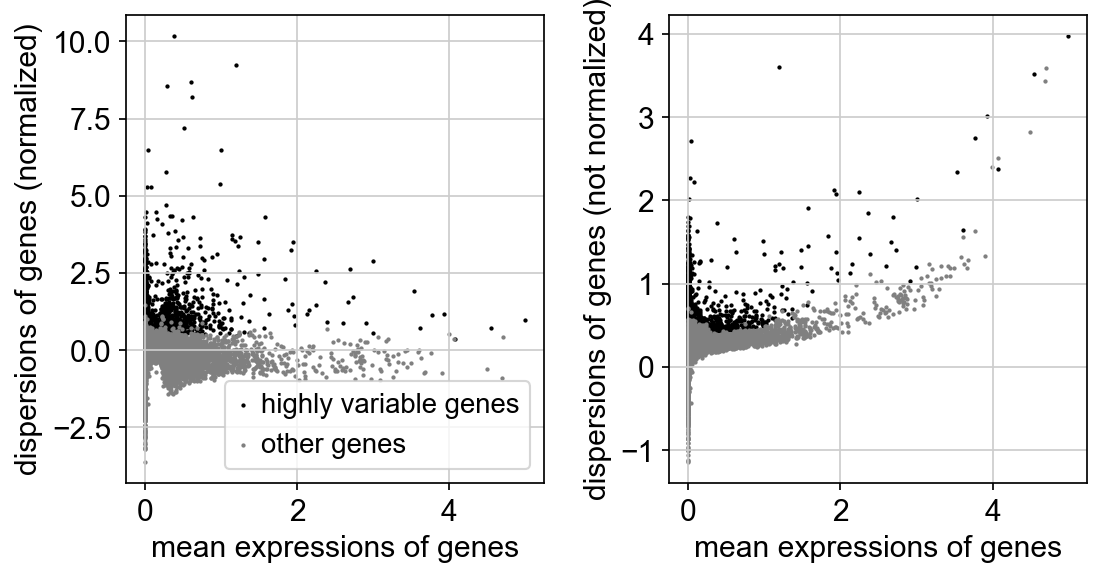

In [13]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [14]:
sc.tl.pca(adata)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function {func}`~scanpy.tl.leiden` or {func}`~scanpy.tl.tsne`. In our experience, there does not seem to be signifigant downside to overestimating the numer of principal components.

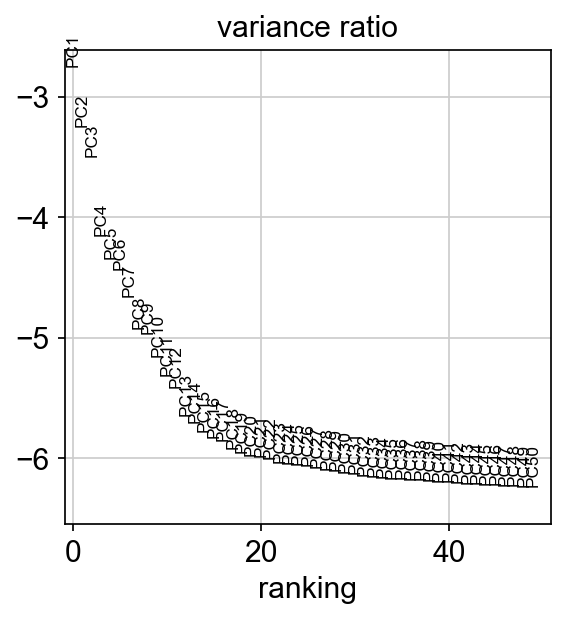

In [15]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

You can also plot the principal components to see if there are any potentially undesired features (e.g. batch, QC metrics) driving signifigant variation in this dataset. In this case, there isn't anything too alarming, but it's a good idea to explore this.

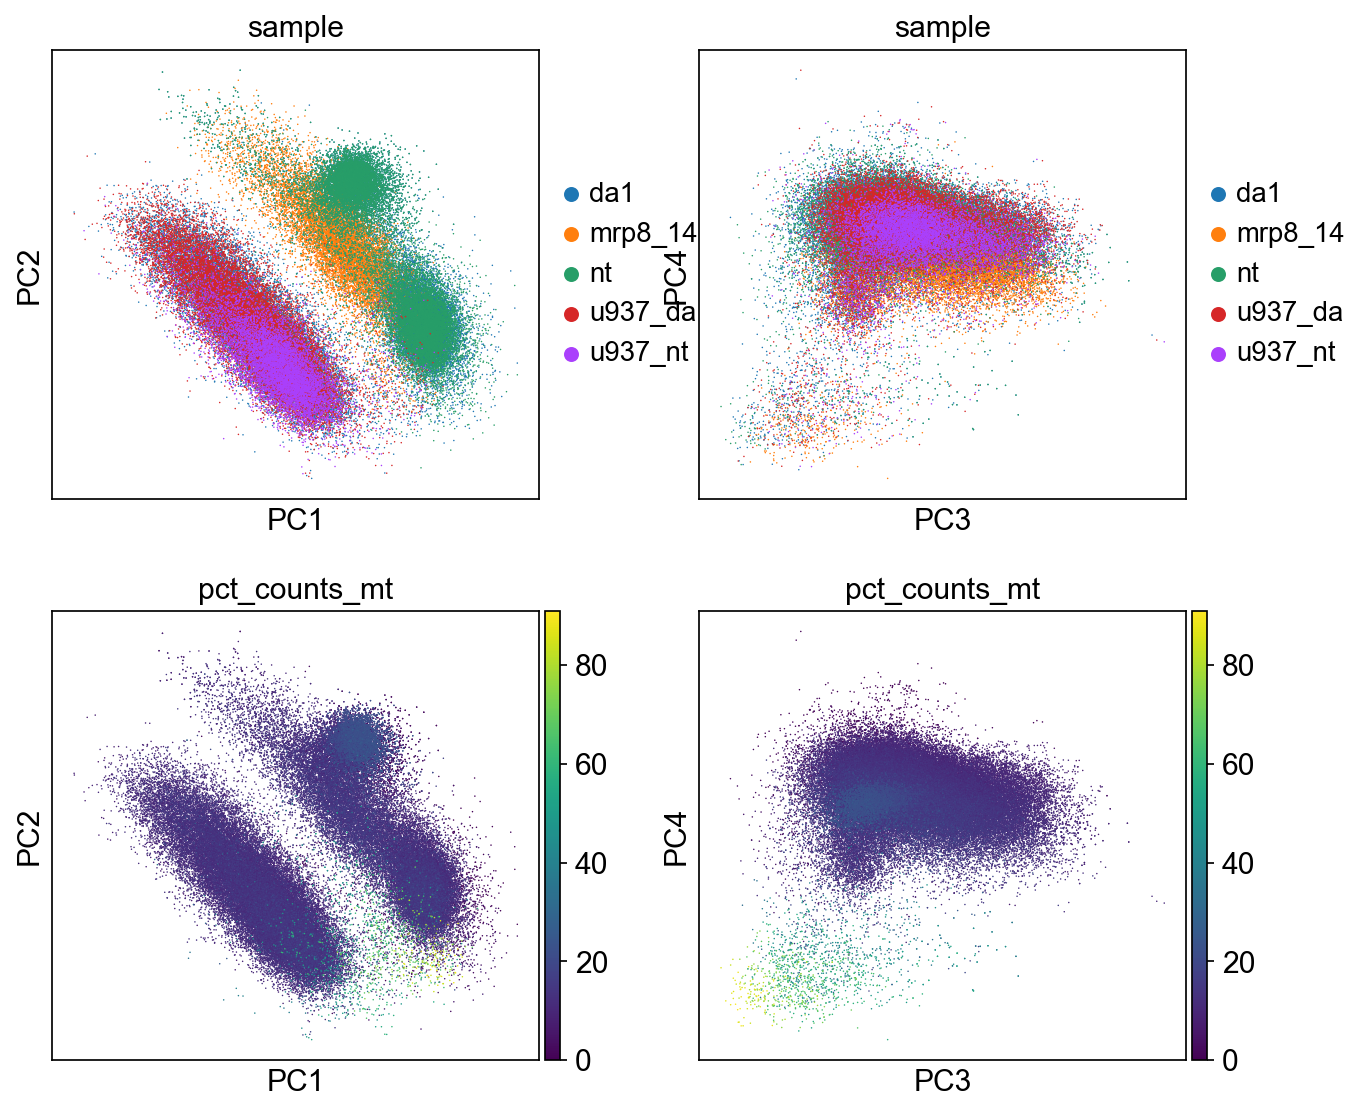

In [16]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

## Nearest neighbor graph constuction and visualization

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix.

In [17]:
sc.pp.neighbors(adata)

This graph can then be embedded in two dimensions for visualiztion with UMAP (McInnes et al., 2018):

In [18]:
sc.tl.umap(adata)

We can now visualize the UMAP according to the `sample`. 

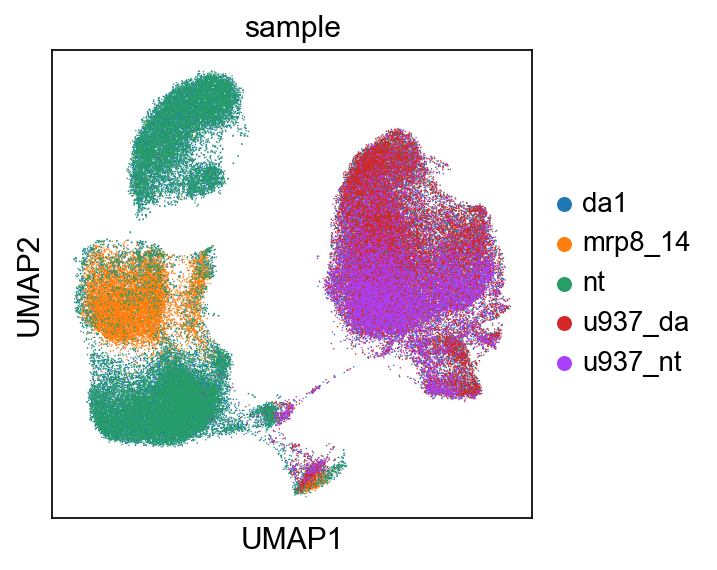

In [19]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

Even though the data considered in this tutorial includes two different samples, we only observe a minor batch effect and we can continue with clustering and annotation of our data. 

If you inspect batch effects in your UMAP it can be beneficial to integrate across samples and perform batch correction/integration. We recommend checking out [`scanorama`](https://github.com/brianhie/scanorama) and [`scvi-tools`](https://scvi-tools.org) for batch integration.

## Clustering

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) {cite}`Traag2019`. Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [20]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata)

C:\Users\kssri\AppData\Local\Temp\ipykernel_14448\859884257.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


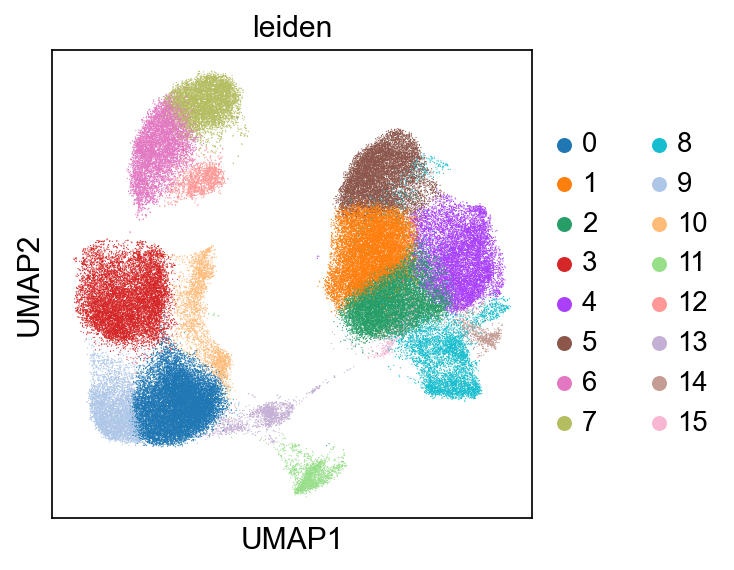

In [21]:
sc.pl.umap(adata, color=["leiden"])

## Re-assess quality control and cell filtering 

As indicated before, we will now re-assess our filtering strategy by visualizing different QC metrics using UMAP. 

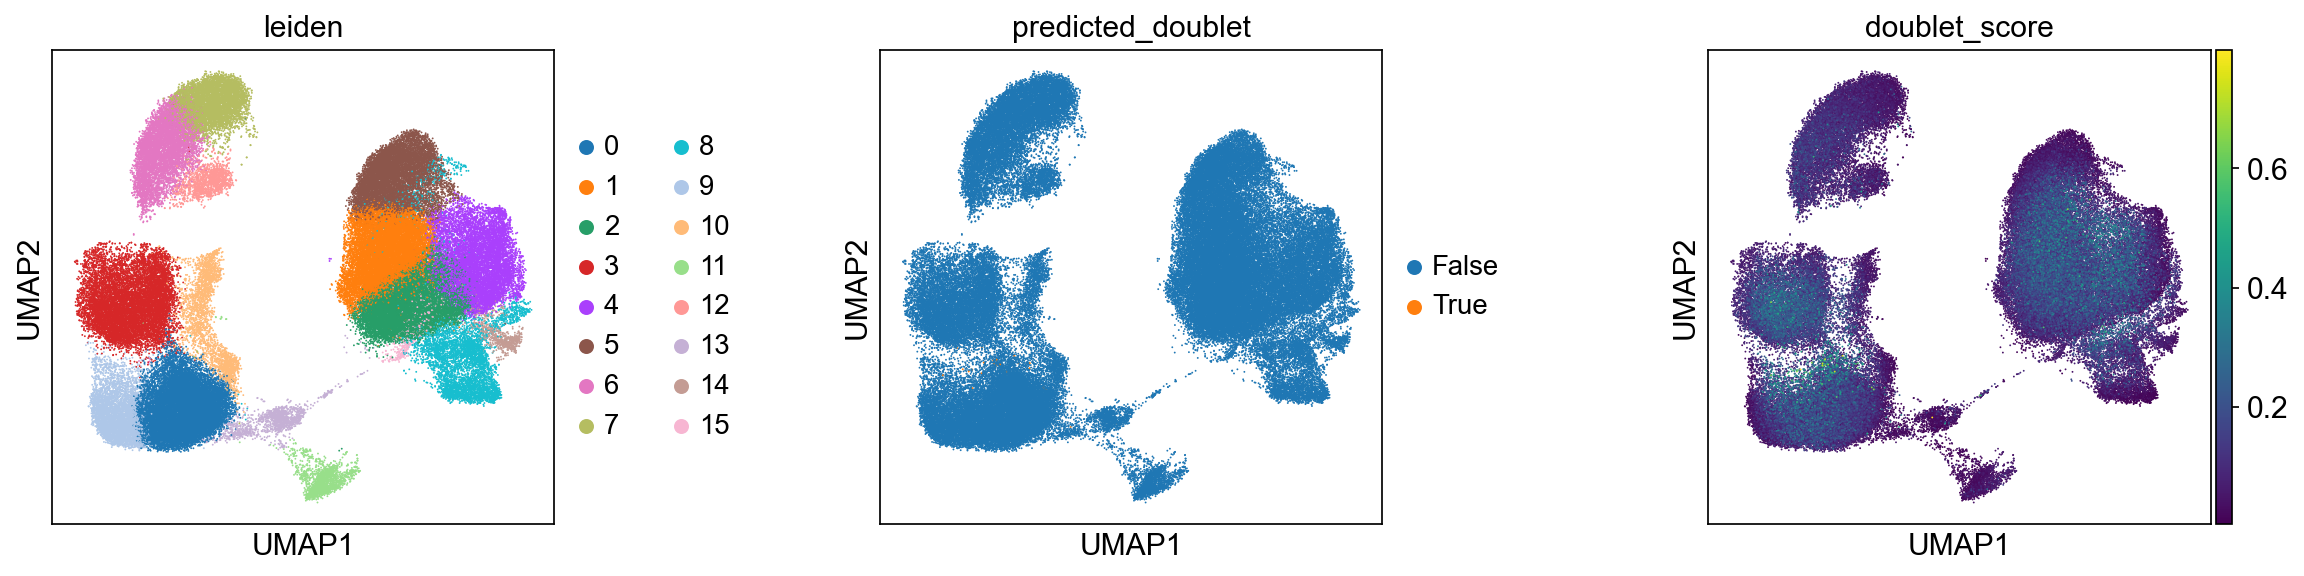

In [22]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

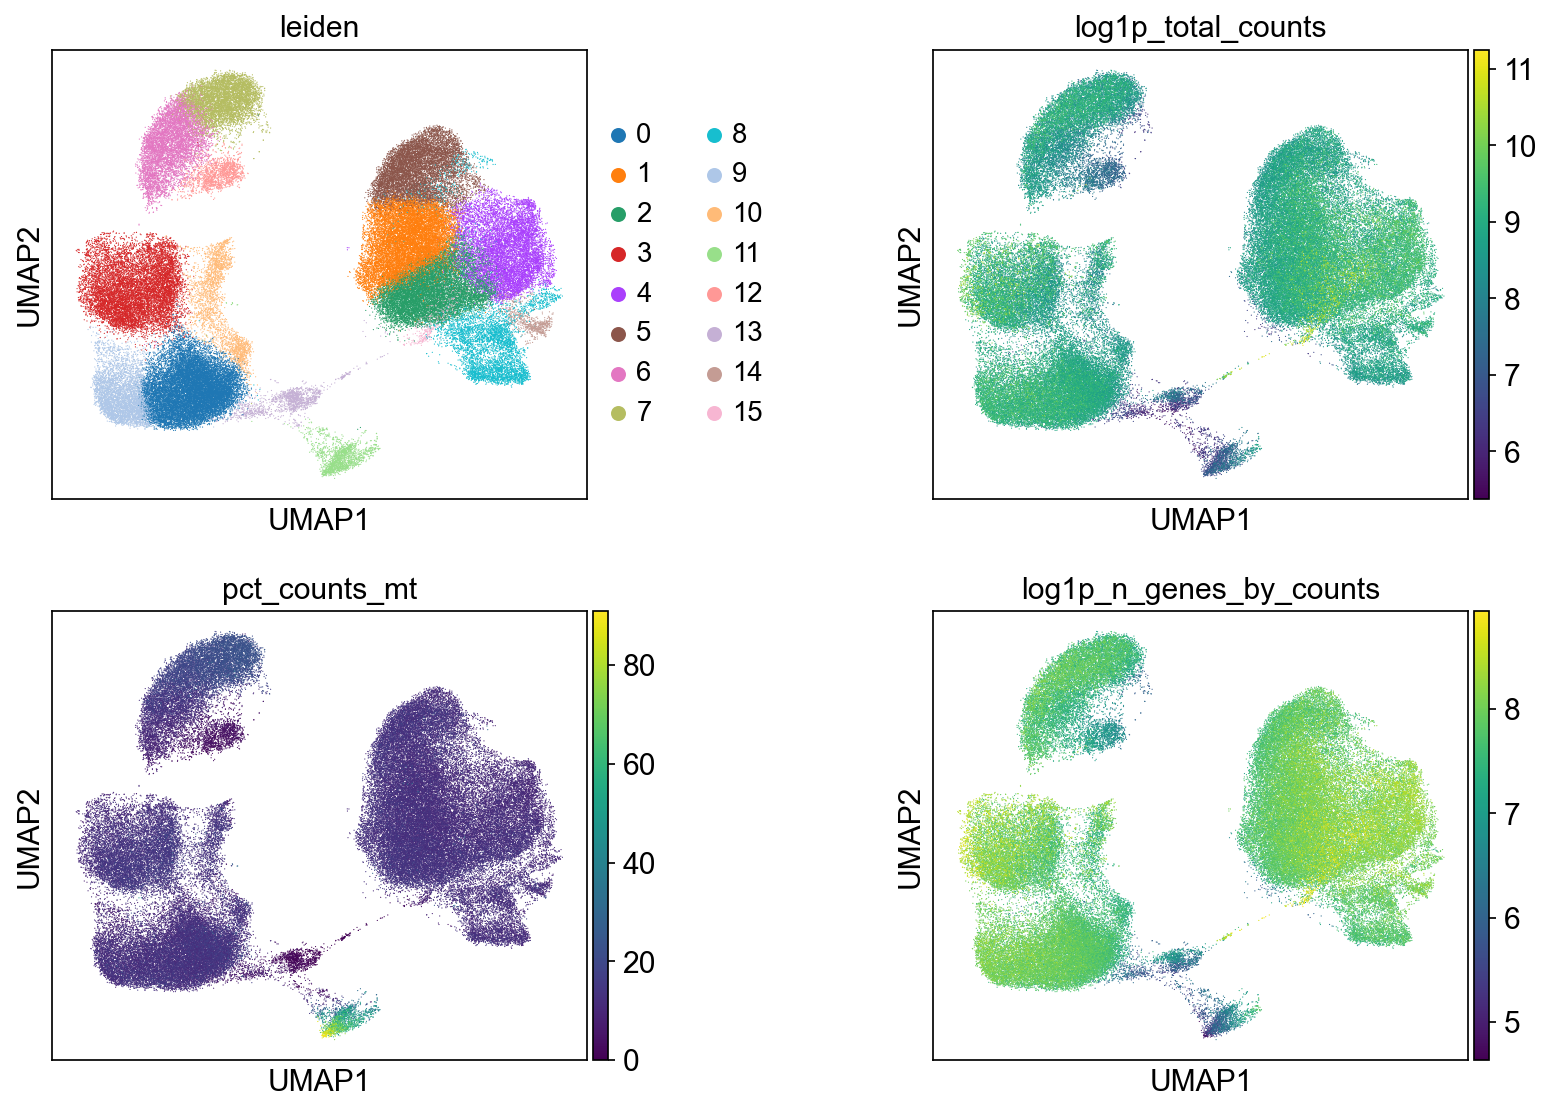

In [23]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)